# XGBoost and LightGBM: High-Performance Modeling for Porphyry Copper Prediction

In this notebook, we build and evaluate two advanced machine learning models — XGBoost and LightGBM — to predict porphyry copper deposit probability based on selected geoscientific features.

Although both models are implementations of gradient boosting decision trees (GBDT), they differ significantly in how they build trees, optimize computation, and respond to feature structures. XGBoost uses a level-wise tree growth strategy and is known for robustness and stability. LightGBM, on the other hand, adopts a leaf-wise growth strategy, making it faster and more memory-efficient, often with slightly better accuracy if well tuned.

We train both models side by side to:
- Validate the consistency of predictions across implementations
- Compare performance metrics such as ROC AUC, recall, and F1
- Analyze and interpret differences in feature importance
- Identify the best model for downstream deployment or fusion

This dual-model strategy enhances the scientific rigor and robustness of our mineral prospectivity modeling workflow.


## 1. Data Loading and Splitting

We load the final feature matrix `train_dataset_selected.csv`, which includes preprocessed features selected through earlier statistical and model-driven techniques. The dataset is then split into training and testing subsets using stratified sampling to preserve class distribution. This ensures that the proportion of porphyry and non-porphyry samples remains consistent in both sets, allowing fair evaluation.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the preprocessed dataset
df = pd.read_csv("../../data/processed/train_dataset_selected.csv")

# Split features and labels
X = df.drop(columns=["label"])
y = df["label"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## 2. Training XGBoost Classifier and LightGBM Classifier

We initialize an `XGBClassifier` with commonly effective default hyperparameters such as 200 trees, maximum depth of 6, and a learning rate of 0.1. The model is then fitted on the training data. We suppress label encoder warnings and use `logloss` as the evaluation metric. After training, we generate both class predictions and class probabilities for evaluation.

In parallel, we train a `LGBMClassifier` with parameters similar to those used in XGBoost to enable a fair comparison. We also apply `class_weight='balanced'` to compensate for any minor class imbalance. Like XGBoost, the model produces both predicted classes and class probabilities for downstream evaluation and ROC analysis.

In [3]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)

# Predict
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]


lgb_model = LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42
)

lgb_model.fit(X_train, y_train)

# Predict
lgb_pred = lgb_model.predict(X_test)
lgb_proba = lgb_model.predict_proba(X_test)[:, 1]

d:\02_Study\University\2025-02_COMP5703_Capstone_Project\2025-04_Github\CS25_CopperCoreAI_ML\geoenv\lib\site-packages\xgboost\training.py:183: UserWarning: [21:57:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 760, number of negative: 1520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 2280, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

## 3. Evaluate and Compare Both Models

We evaluate both XGBoost and LightGBM using a consistent set of classification metrics: precision, recall, F1-score, and ROC AUC. We print out the classification reports and visualize confusion matrices to observe performance on each class. We then plot ROC curves and compute AUC scores to assess how well each model distinguishes between porphyry and non-porphyry classes across different thresholds.

Special attention is given to recall for class 1 (porphyry), as minimizing false negatives is crucial in mineral exploration. A higher recall implies fewer missed true deposits, making the model more practical in real-world applications.

XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       380
           1       0.90      0.92      0.91       190

    accuracy                           0.94       570
   macro avg       0.93      0.94      0.93       570
weighted avg       0.94      0.94      0.94       570

ROC AUC: 0.9805


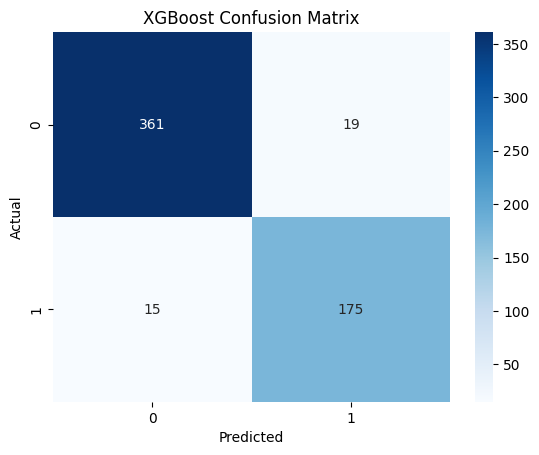

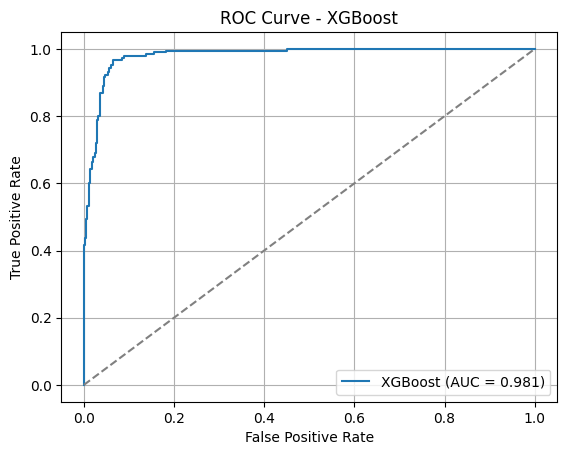

LightGBM Classification Report
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       380
           1       0.88      0.95      0.91       190

    accuracy                           0.94       570
   macro avg       0.93      0.94      0.93       570
weighted avg       0.94      0.94      0.94       570

ROC AUC: 0.9835


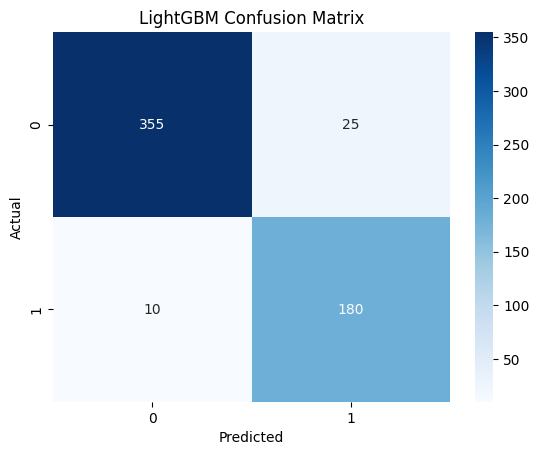

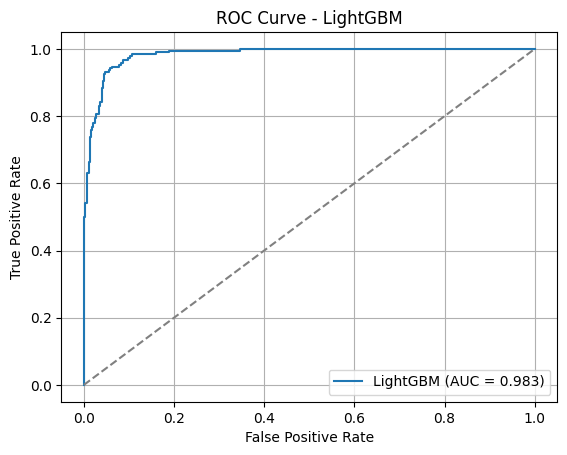

In [5]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"{name} Classification Report")
    print(classification_report(y_true, y_pred))

    auc = roc_auc_score(y_true, y_proba)
    print(f"ROC AUC: {auc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

evaluate_model("XGBoost", y_test, xgb_pred, xgb_proba)
evaluate_model("LightGBM", y_test, lgb_pred, lgb_proba)


## 4. Feature Importance

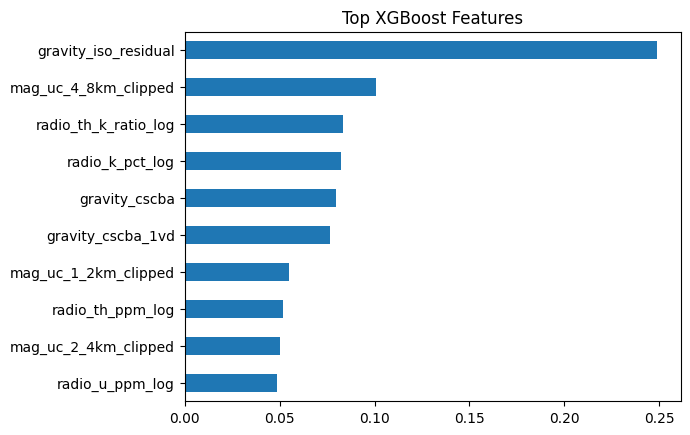

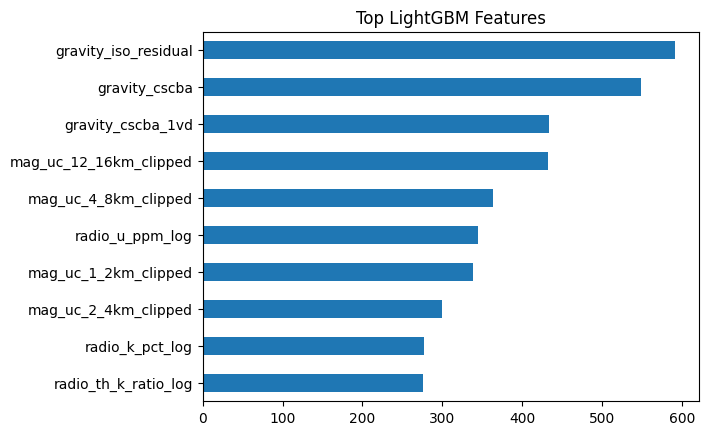

In [6]:
import numpy as np

xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns)
xgb_importance.sort_values().tail(10).plot(kind="barh", title="Top XGBoost Features")
plt.show()

lgb_importance = pd.Series(lgb_model.feature_importances_, index=X.columns)
lgb_importance.sort_values().tail(10).plot(kind="barh", title="Top LightGBM Features")
plt.show()


## 5. Parameter Tuning Strategy

We begin with a coarse grid search over key parameters — `n_estimators`, `max_depth`, and `learning_rate` — to quickly explore the model's performance behavior.

Once we identify the general trend, we can expand the search space to include additional parameters like `subsample`, `colsample_bytree`, `min_child_weight`, and regularization terms for further optimization.

In [8]:
from sklearn.model_selection import GridSearchCV

# XGBoost parameter grid
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1]
}
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_grid = GridSearchCV(xgb, xgb_params, scoring='recall', cv=3, n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)
xgb_best_params = xgb_grid.best_params_

# LightGBM parameter grid
lgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1]
}
lgb = LGBMClassifier(class_weight='balanced', random_state=42)
lgb_grid = GridSearchCV(lgb, lgb_params, scoring='recall', cv=3, n_jobs=-1, verbose=1)
lgb_grid.fit(X_train, y_train)
lgb_best_params = lgb_grid.best_params_

xgb_best_params, lgb_best_params

Fitting 3 folds for each of 8 candidates, totalling 24 fits


d:\02_Study\University\2025-02_COMP5703_Capstone_Project\2025-04_Github\CS25_CopperCoreAI_ML\geoenv\lib\site-packages\xgboost\training.py:183: UserWarning: [22:21:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 760, number of negative: 1520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 2280, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

({'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100},
 {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200})

In [9]:
# XGBoost
from xgboost import XGBClassifier

xgb_best = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)
xgb_best.fit(X_train, y_train)

# LightGBM
from lightgbm import LGBMClassifier

lgb_best = LGBMClassifier(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
lgb_best.fit(X_train, y_train)


d:\02_Study\University\2025-02_COMP5703_Capstone_Project\2025-04_Github\CS25_CopperCoreAI_ML\geoenv\lib\site-packages\xgboost\training.py:183: UserWarning: [22:30:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 760, number of negative: 1520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 2280, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=4,
               n_estimators=200, random_state=42)

XGBoost (Tuned) Classification Report
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       380
           1       0.88      0.90      0.89       190

    accuracy                           0.92       570
   macro avg       0.91      0.92      0.92       570
weighted avg       0.93      0.92      0.92       570

ROC AUC: 0.9765


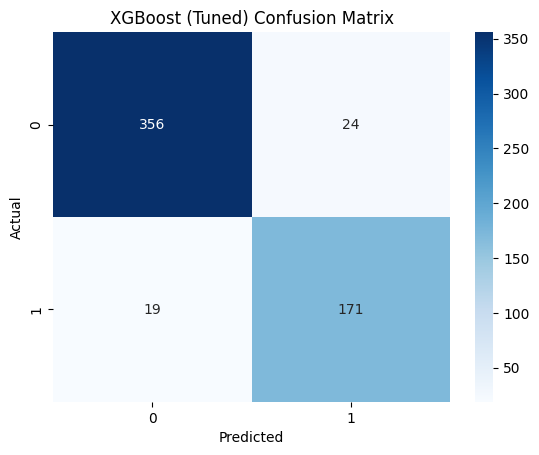

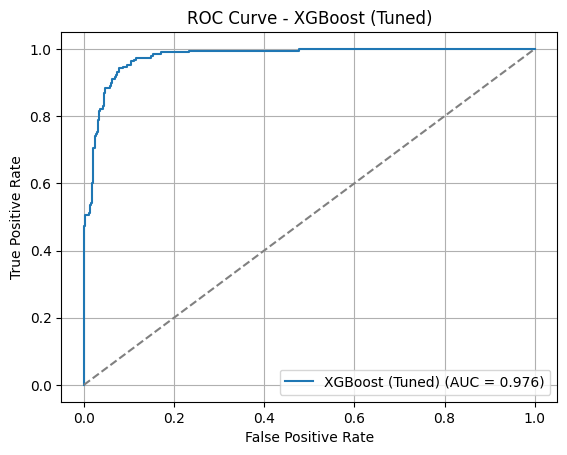

LightGBM (Tuned) Classification Report
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       380
           1       0.83      0.96      0.89       190

    accuracy                           0.92       570
   macro avg       0.91      0.93      0.92       570
weighted avg       0.93      0.92      0.92       570

ROC AUC: 0.9732


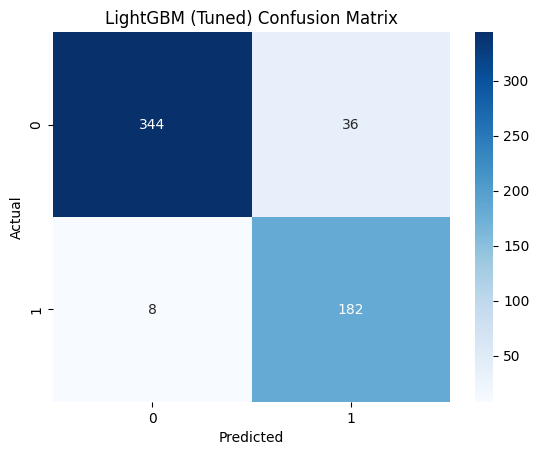

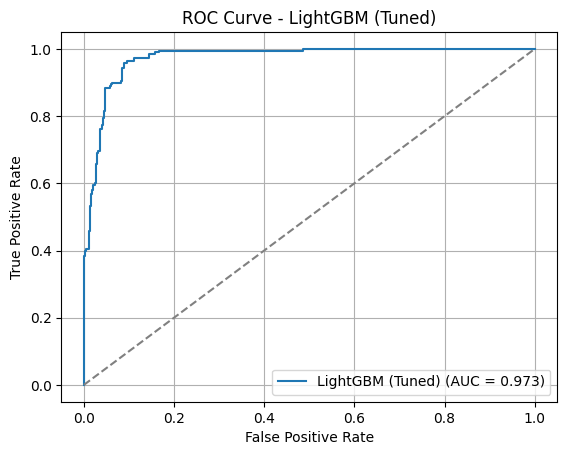

In [10]:
xgb_pred = xgb_best.predict(X_test)
xgb_proba = xgb_best.predict_proba(X_test)[:, 1]
evaluate_model("XGBoost (Tuned)", y_test, xgb_pred, xgb_proba)

lgb_pred = lgb_best.predict(X_test)
lgb_proba = lgb_best.predict_proba(X_test)[:, 1]
evaluate_model("LightGBM (Tuned)", y_test, lgb_pred, lgb_proba)


## 6.Model Comparison Summary
The evaluation results indicate that both XGBoost and LightGBM models exhibit strong predictive performance on the task of distinguishing porphyry copper deposits from non-deposits. However, there are subtle differences that emerge between tuned and untuned versions in terms of various metrics.

**XGBoost (Tuned vs. Untuned)**
Untuned XGBoost achieves an excellent AUC of 0.981, precision of 0.90, and recall of 0.92 for the positive class (porphyry). It has fewer false negatives, which is critical in mineral exploration.

Tuned XGBoost slightly drops to an AUC of 0.976, and its recall for the positive class decreases to 0.90 and precision slightly decreases to 0.88. The balanced trade-off between precision and recall is maintained, but it does not significantly outperform the untuned version.

**LightGBM (Tuned vs. Untuned)**
Untuned LightGBM already performs impressively, with AUC of 0.984, recall of 0.95, and precision of 0.88 for the porphyry class.

Tuned LightGBM, despite a slightly lower AUC of 0.973, achieves higher recall (0.96) for porphyry class with slightly reduced precision (0.83). This model maximizes true positives but increases false positives.

In [11]:
import joblib
joblib.dump(xgb_model, "../../models/xgboost_model.pkl")
joblib.dump(lgb_best, "../../models/lightgbm_model.pkl")

['../../models/lightgbm_model.pkl']